# Generate soma stats

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/data_utils/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


def grouped_obs_percent(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        X.data = X.data > 0.01
        perc = np.asarray(np.sum(X,axis=0)/X.shape[0]).reshape(-1)
        out[group] = [round(i, 2) for i in perc ]
    return out


def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

# Prepare INPUT

## Load andata

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')

### Load cell clusters annotation

In [3]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot)
adata.obs['lineage'].value_counts()

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Mesenchymal_GATA2    84229
Mesenchymal_LHX9     62747
preGranulosa         38881
Sertoli              34969
lowQC                34677
Supporting           31454
CoelEpi              24297
Epithelial           20222
GermCells            14516
Endothelial          14484
PV                   12679
Doublet               5821
Immune                5533
Neural                3783
SMCs                  3044
FetalLeydig           2426
cont                  1432
Erythroid             1371
Name: lineage, dtype: int64

In [4]:
# adata.obs['lineage'] = adata.obs['clusters_manual'].tolist()
# adata.obs['lineage'] = adata.obs['lineage'].replace(regex=r'Supporting_female', value='Supporting')
# set(adata.obs['lineage'] )


In [5]:
# del adata.obs['study']
# del adata.obs['stage']
# del adata.obs['location']
# del adata.obs['5v1.1']
# del adata.obs['batch_collection']
# del adata.obs['TP']
# del adata.obs['cryopreserved']
# del adata.obs['clusters_manual']
# del adata.obs['batch']
# del adata.obs['clusters']
# del adata.obs['sub_clusters']

# Import sub-analysis

In [7]:
# Add somatic cluster subname
meta = pd.read_csv(path_to_gonads+'FCA-gonads_somatic_annotated.csv')
meta = meta.set_index('Unnamed: 0')
meta['celltype'] = ['Somatic.'+i for i in meta['celltype'] ]
meta.head()


# Add germ cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_germcellsClean_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF['celltype'] = ['Germ.'+i for i in metaF['celltype'] ]
metaF.head()

# Add endothelials
metaEnd = pd.read_csv('/nfs/team292/vl6/immune_fetal_gonads/endothelial.csv')
metaEnd = metaEnd.set_index('Unnamed: 0')
metaEnd['celltype'] = ['Endo.'+i for i in metaEnd['celltype'] ]
metaEnd.head()


# Add epithelials cluster subname
metaEpi = pd.read_csv(path_to_gonads+'/FCA-gonads_sPAX8_annotated.csv')
metaEpi = metaEpi.set_index('Unnamed: 0')
metaEpi['celltype'] = ['Epi.'+i for i in metaEpi['celltype'] ]
metaEpi = metaEpi [ metaEpi['lineage'] == 'Epithelial' ]
metaEpi.head()


cell_annotM = meta['celltype'].to_dict()
cell_annotF = metaF['celltype'].to_dict()
cell_annotE = metaEpi['celltype'].to_dict()
cell_annotEnd = metaEnd['celltype'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF, **cell_annotE, **cell_annotEnd}
adata.obs['celltype'] = adata.obs_names.map(cell_annot)
adata.obs['celltype'] = adata.obs['celltype'].fillna(adata.obs['lineage'])
adata.obs['celltype'].value_counts()

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Mesenchymal_GATA2               84229
Somatic.Sertoli                 36917
Somatic.Ti                      34808
lowQC                           34516
Somatic.Oi                      25730
Somatic.preGC_IIb               23825
Somatic.preGC_I                 15599
Somatic.preGC_IIa               13772
PV                              12679
Epithelial                       9113
Somatic.OSE                      8222
Somatic.early_supporting         5894
Doublet                          5821
Somatic.CoelEpi_LHX9             5547
Immune                           5533
Endo.Fenestrated_EC              5385
Epi.Epi_wolffian                 5282
Somatic.Gi                       4749
Somatic.CoelEpi_GATA2            4050
Neural                           3783
Germ.PGC                         3764
Somatic.early_sPAX8              3648
GermCells                        3523
Endo.Venous_EC                   3450
SMCs                             3044
Somatic.FetalLeydig              2874
Endothelial 

In [8]:
# Clean cells
adata = adata[[ i not in ['cont', 'Doublet', 'lowQC', 'Supporting' ,'CoelEpi',  'Endothelial', 'Epithelial', 'GermCells', 'Mesenchymal_LHX9', 'preGranulosa']  for i in adata.obs.celltype ]]
adata = adata[[ 'cont' not in i  for i in adata.obs.celltype ]]
adata = adata[[ 'lowQC' not in i  for i in adata.obs.celltype ]]
adata = adata[[ 'Doublet' not in i  for i in adata.obs.celltype ]]
# adata = adata[[ 'cycling' not in i  for i in adata.obs.celltype ]]
adata.obs['celltype'].value_counts(dropna = False)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mesenchymal_GATA2               84229
Somatic.Sertoli                 36917
Somatic.Ti                      34808
Somatic.Oi                      25730
Somatic.preGC_IIb               23825
Somatic.preGC_I                 15599
Somatic.preGC_IIa               13772
PV                              12679
Somatic.OSE                      8222
Somatic.early_supporting         5894
Somatic.CoelEpi_LHX9             5547
Immune                           5533
Endo.Fenestrated_EC              5385
Epi.Epi_wolffian                 5282
Somatic.Gi                       4749
Somatic.CoelEpi_GATA2            4050
Neural                           3783
Germ.PGC                         3764
Somatic.early_sPAX8              3648
Endo.Venous_EC                   3450
SMCs                             3044
Somatic.FetalLeydig              2874
Epi.Epi_glomerular               2657
Epi.Epi_Mullerian                2278
Germ.oogonia_STRA8               2203
Somatic.late_sPAX8               2118
Germ.oogonia

# Barcode stats

In [9]:
adata.obs.to_csv(str(sc.settings.figdir)+'/barcodes_stats.csv')

# MARKERS

In [53]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
sc.set_figure_params(figsize=(4, 4))
palette = ['#199de5', '#fbbc04']

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


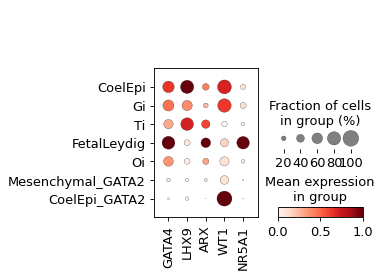

In [52]:
adata.obs['lineage2'] = adata.obs['lineage'].tolist()
adata.obs.at[adata.obs['celltype'] == 'Somatic.CoelEpi_GATA2', 'lineage2'] = 'CoelEpi_GATA2'
adata.obs.at[adata.obs['celltype'] == 'Somatic.Gi', 'lineage2'] = 'Gi'
adata.obs.at[adata.obs['celltype'] == 'Somatic.Ti', 'lineage2'] = 'Ti'
adata.obs.at[adata.obs['celltype'] == 'Somatic.Oi', 'lineage2'] = 'Oi'
XX = adata[[ i in ['CoelEpi', 'Mesenchymal_LHX9', 'Mesenchymal_GATA2',   'FetalLeydig'] for i in adata.obs.lineage]]
XX = XX[[ i not in ['Mesenchymal_LHX9'] for i in XX.obs.lineage2]]

XX.obs['lineage2'] = XX.obs['lineage2'].astype('category')
XX.obs['lineage2'].cat.reorder_categories(['CoelEpi', 
#                                            'Supporting', 'Sertoli','preGranulosa', 
                                           'Gi', 'Ti', 'FetalLeydig', 'Oi',
                                           'Mesenchymal_GATA2', 
                                              'CoelEpi_GATA2'], inplace=True)
sc.pl.dotplot(XX, 
              ['GATA4', 'LHX9', 'ARX', 'WT1', 'NR5A1'], groupby='lineage2', standard_scale = 'var',
             save='gonadalTFs.pdf')

In [9]:
import rpy2.rinterface_lib.callbacks
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


In [10]:
#  Downsample to the smallest pop size
target_cells = 100
adata.obs['celltype'].astype('category')

adata.obs['cell'] = adata.obs.index
adatas = [adata[adata.obs['celltype'].isin([cl])] for cl in set(adata.obs['celltype']) ]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown = adata[[ i in adata_downsampled.obs.cell.tolist() for i in adata.obs['cell'] ]]

sc.pp.filter_genes(adataDown, min_cells=20)

Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.var` of view, copying.


In [11]:
adataDown.obs['celltype'].value_counts(dropna = False)

Somatic.early_supporting    100
Neural                      100
Somatic.OSE                 100
Endo.Fenestrated_EC         100
Germ.oocyte                 100
Endo.Venous_EC              100
Somatic.preGC_I             100
Somatic.Oi                  100
Somatic.early_somatic       100
Germ.oogonia_STRA8          100
Erythroid                   100
Germ.PGC                    100
Epi.Epi_mesonephros         100
Germ.oogonia_meiotic        100
Somatic.preGC_IIa           100
Somatic.Gi                  100
Germ.GC_mitotic             100
Somatic.CoelEpi_GATA2       100
Somatic.preGC_IIb           100
Germ.GC                     100
PV                          100
Germ.pre_spermatogonia      100
Mesenchymal_GATA2           100
Somatic.Ti                  100
Endo.Arterial_EC            100
Somatic.late_sPAX8          100
Somatic.granulosa           100
Somatic.FetalLeydig         100
Germ.pre_oocyte             100
Somatic.early_sPAX8         100
Endo.Lymphatic_EC           100
Endo.Glo

In [12]:
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'PCW', 'sample_source', 'trimester', 'lineage']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

In [13]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 18251 4000 
metadata(6): TP_colors batch_collection_colors ... hvg sex_colors
assays(1): X
rownames(18251): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(222): gene_ids.0 feature_types.0 ... variances
  variances_norm
colnames(4000): FCA_GND8047885_AAACGGGTCGTGGACC
  FCA_GND8047885_AAATGCCAGGTGACCA ...
  HCA_F_GON10941969_TTGCCGTGTGTCGCTG HCA_F_GON10941969_TTGTAGGAGATGCCAG
colData names(4): sex somatic_celltype_v2 celltype cell
reducedDimNames(0):
altExpNames(0):


In [14]:
%%R -o mrks

library(SoupX)
counts <- assay(adataDown, "X")
colnames(counts) <- colnames(adataDown)
rownames(counts) <- rownames(adataDown)
mrks = quickMarkers(counts, colData(adataDown)$celltype, N = 100) # where clusters is the cell type assignment and 100 means I want the top 100 genes per cluster that pass the hypergeometric test

In [15]:
mrks[ mrks.cluster == 'Epi.Epi_mesonephros' ]

,gene,cluster,geneFrequency,geneFrequencyOutsideCluster,geneFrequencySecondBest,geneFrequencyGlobal,secondBestClusterName,tfidf,idf,qval
701,CDH6,Epi.Epi_mesonephros,0.94,0.072564,0.52,0.09425,Epi.Epi_wolffian,2.220096,2.361804,4.920246e-89
702,TM4SF4,Epi.Epi_mesonephros,0.55,0.007692,0.14,0.02125,Epi.Epi_wolffian,2.118269,3.851398,3.163541e-70
703,KLK6,Epi.Epi_mesonephros,0.84,0.061538,0.80,0.08100,Epi.Epi_glomerular,2.111177,2.513306,1.631865e-75
704,KREMEN2,Epi.Epi_mesonephros,0.81,0.062564,0.46,0.08125,Somatic.CoelEpi_GATA2,2.033282,2.510224,3.686499e-70
705,LRP2,Epi.Epi_mesonephros,0.67,0.040000,0.39,0.05575,Epi.Epi_wolffian,1.934208,2.886878,4.804849e-60
...,...,...,...,...,...,...,...,...,...,...
796,TUBB4A,Epi.Epi_mesonephros,0.65,0.156410,0.52,0.16875,Epi.Epi_wolffian,1.156569,1.779337,2.371146e-25
797,C5orf49,Epi.Epi_mesonephros,0.37,0.035641,0.24,0.04400,Epi.Epi_Mullerian,1.155719,3.123566,7.149699e-24
798,AGRN,Epi.Epi_mesonephros,0.81,0.225641,0.57,0.24025,Somatic.CoelEpi_GATA2,1.155121,1.426075,1.477925e-31
799,RERG,Epi.Epi_mesonephros,0.53,0.102564,0.41,0.11325,Somatic.CoelEpi_GATA2,1.154423,2.178158,3.523824e-23


In [16]:
mrks.to_csv(str(sc.settings.figdir)+'/TFIDF.csv')

# Compute cluster stats

In [17]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)                                                                                                            
# sc.pp.scale(adata, max_value=10)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
sc.pp.filter_cells(adata, min_genes=1000)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
# percentatge expression
percent = grouped_obs_percent(adata, 'celltype')
pd.DataFrame(percent).to_csv(str(sc.settings.figdir)+'/percent.csv')
# average expression
means = grouped_obs_mean(adata, 'celltype')
pd.DataFrame(means).to_csv(str(sc.settings.figdir)+'/average_log.csv')